# Movie Analysis

Our goal is to identify:
- top genre combinations 
- top producers
- directors
- actors
- actresses

We will focus on two metrics:
- average Return on Investment
- average profit

In [1]:
import sqlite3
import numpy as np
import pandas as pd 
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import recordlinkage
from recordlinkage.preprocessing import clean

## IMDb database

Lets connect to the database and explore the data

In [2]:
path = "zippedData/im.db"
conn = sqlite3.connect(path)
cursor = conn.cursor()

In [3]:
# to see all the tables in the database.

imdb_df = pd.read_sql(
    """
    SELECT *
    FROM sqlite_master
    """
, conn
)

imdb_df[imdb_df['type'] == 'table']

,type,name,tbl_name,rootpage,sql
0,table,movie_basics,movie_basics,2,"CREATE TABLE ""movie_basics"" (\n""movie_id"" TEXT..."
1,table,directors,directors,3,"CREATE TABLE ""directors"" (\n""movie_id"" TEXT,\n..."
2,table,known_for,known_for,4,"CREATE TABLE ""known_for"" (\n""person_id"" TEXT,\..."
3,table,movie_akas,movie_akas,5,"CREATE TABLE ""movie_akas"" (\n""movie_id"" TEXT,\..."
4,table,movie_ratings,movie_ratings,6,"CREATE TABLE ""movie_ratings"" (\n""movie_id"" TEX..."
5,table,persons,persons,7,"CREATE TABLE ""persons"" (\n""person_id"" TEXT,\n ..."
6,table,principals,principals,8,"CREATE TABLE ""principals"" (\n""movie_id"" TEXT,\..."
7,table,writers,writers,9,"CREATE TABLE ""writers"" (\n""movie_id"" TEXT,\n ..."


In [4]:
query1 = """ SELECT * FROM movie_basics ORDER BY -start_year LIMIT 10"""
pd.read_sql(query1, conn)

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt5174640,100 Years,100 Years,2115,None,Drama
1,tt5637536,Avatar 5,Avatar 5,2027,None,"Action,Adventure,Fantasy"
2,tt10300398,Untitled Star Wars Film,Untitled Star Wars Film,2026,None,Fantasy
3,tt3095356,Avatar 4,Avatar 4,2025,None,"Action,Adventure,Fantasy"
4,tt10300396,Untitled Star Wars Film,Untitled Star Wars Film,2024,None,None
5,tt6149054,Fantastic Beasts and Where to Find Them 5,Fantastic Beasts and Where to Find Them 5,2024,None,"Adventure,Family,Fantasy"
6,tt10255736,Untitled Marvel Project,Untitled Marvel Project,2023,None,Action
7,tt10298848,Untitled Disney Live-Action Project,Untitled Disney Live-Action Project,2023,None,None
8,tt1757678,Avatar 3,Avatar 3,2023,None,"Action,Adventure,Drama"
9,tt6258542,Wraith of the Umbra and Eidolon II,Wraith of the Umbra and Eidolon II,2023,None,"Adventure,Drama,Fantasy"


In [5]:
# get column info
cursor.execute("PRAGMA table_info(movie_basics)")
cursor.fetchall()

[(0, 'movie_id', 'TEXT', 0, None, 0),
 (1, 'primary_title', 'TEXT', 0, None, 0),
 (2, 'original_title', 'TEXT', 0, None, 0),
 (3, 'start_year', 'INTEGER', 0, None, 0),
 (4, 'runtime_minutes', 'REAL', 0, None, 0),
 (5, 'genres', 'TEXT', 0, None, 0)]

In [6]:
query4 = """ SELECT COUNT(*) FROM movie_basics"""
pd.read_sql(query4, conn)

,COUNT(*)
0,146144


In [7]:
query2 = """ SELECT * FROM movie_ratings LIMIT 5"""
pd.read_sql(query2, conn)

,movie_id,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559
2,tt1042974,6.4,20
3,tt1043726,4.2,50352
4,tt1060240,6.5,21


In [8]:
query11 = """ SELECT * FROM directors LIMIT 5"""
pd.read_sql(query11, conn)

,movie_id,person_id
0,tt0285252,nm0899854
1,tt0462036,nm1940585
2,tt0835418,nm0151540
3,tt0835418,nm0151540
4,tt0878654,nm0089502


Let's combine the tables to include movie data, ratings, as well as the producers, directors, 
and actors who worked on the movie

In [9]:
query201 = """
    WITH ranked_directors AS (
    SELECT
        d.movie_id,
        p.primary_name AS director_name,
        ROW_NUMBER() OVER (PARTITION BY d.movie_id ORDER BY d.person_id) AS director_rank
    FROM directors d
    JOIN persons p ON d.person_id = p.person_id
    GROUP BY d.movie_id, p.primary_name, d.person_id
),

ranked_principals AS (
    SELECT 
        p.movie_id,
        per.primary_name AS person_name,
        p.category,
        ROW_NUMBER() OVER (PARTITION BY p.movie_id, p.category ORDER BY p.person_id) AS person_rank
    FROM principals p
    JOIN persons per ON p.person_id = per.person_id
    WHERE p.category IN ('actor', 'actress', 'producer')
)

SELECT 
    mr.movie_id AS imdb_movie_id, 
    mb.primary_title, 
    mr.averagerating AS average_rating, 
    mr.numvotes, 
    mb.start_year, 
    mb.runtime_minutes, 
    mb.genres, 
    MAX(CASE WHEN rd.director_rank = 1 THEN rd.director_name END) AS director1, 
    MAX(CASE WHEN rd.director_rank = 2 THEN rd.director_name END) AS director2,
    MAX(CASE WHEN rp.category = 'actress' AND rp.person_rank = 1 THEN rp.person_name END) AS actress1,
    MAX(CASE WHEN rp.category = 'actress' AND rp.person_rank = 2 THEN rp.person_name END) AS actress2,
    MAX(CASE WHEN rp.category = 'actress' AND rp.person_rank = 3 THEN rp.person_name END) AS actress3,
    MAX(CASE WHEN rp.category = 'actor' AND rp.person_rank = 1 THEN rp.person_name END) AS actor1,
    MAX(CASE WHEN rp.category = 'actor' AND rp.person_rank = 2 THEN rp.person_name END) AS actor2,
    MAX(CASE WHEN rp.category = 'actor' AND rp.person_rank = 3 THEN rp.person_name END) AS actor3,
    MAX(CASE WHEN rp.category = 'actor' AND rp.person_rank = 4 THEN rp.person_name END) AS actor4,
    MAX(CASE WHEN rp.category = 'producer' AND rp.person_rank = 1 THEN rp.person_name END) AS producer1,
    MAX(CASE WHEN rp.category = 'producer' AND rp.person_rank = 2 THEN rp.person_name END) AS producer2
FROM movie_ratings mr
JOIN movie_basics mb ON mr.movie_id = mb.movie_id
LEFT JOIN ranked_directors rd ON mr.movie_id = rd.movie_id
LEFT JOIN ranked_principals rp ON mr.movie_id = rp.movie_id
WHERE mr.numvotes >= 30
GROUP BY 
    mr.movie_id, 
    mb.primary_title, 
    mr.averagerating, 
    mr.numvotes, 
    mb.start_year, 
    mb.runtime_minutes, 
    mb.genres
ORDER BY -mr.numvotes

"""
pd.read_sql(query201, conn)

,imdb_movie_id,primary_title,average_rating,numvotes,start_year,runtime_minutes,genres,director1,director2,actress1,actress2,actress3,actor1,actor2,actor3,actor4,producer1,producer2
0,tt1375666,Inception,8.8,1841066,2010,148.0,"Action,Adventure,Sci-Fi",Christopher Nolan,None,Ellen Page,None,None,Leonardo DiCaprio,Joseph Gordon-Levitt,Ken Watanabe,None,Emma Thomas,None
1,tt1345836,The Dark Knight Rises,8.4,1387769,2012,164.0,"Action,Thriller",Christopher Nolan,None,Anne Hathaway,None,None,Gary Oldman,Christian Bale,Tom Hardy,None,Charles Roven,Emma Thomas
2,tt0816692,Interstellar,8.6,1299334,2014,169.0,"Adventure,Drama,Sci-Fi",Christopher Nolan,None,Anne Hathaway,Jessica Chastain,Mackenzie Foy,Matthew McConaughey,None,None,None,Lynda Obst,Emma Thomas
3,tt1853728,Django Unchained,8.4,1211405,2012,165.0,"Drama,Western",Quentin Tarantino,None,Kerry Washington,None,None,Leonardo DiCaprio,Jamie Foxx,Christoph Waltz,None,Reginald Hudlin,Pilar Savone
4,tt0848228,The Avengers,8.1,1183655,2012,143.0,"Action,Adventure,Sci-Fi",Joss Whedon,None,Scarlett Johansson,None,None,Robert Downey Jr.,Chris Evans,Jeremy Renner,None,Kevin Feige,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43735,tt9378760,Sarah Millican: Control Enthusiast Live,6.9,30,2018,82.0,Comedy,Brian Klein,None,None,None,None,None,None,None,None,None,None
43736,tt9442146,Hüddam 2,5.3,30,2019,92.0,"Drama,Horror,Thriller",Utku Uçar,None,Seyda Ipek Baykal,Ayyildiz Beslen,None,Hakan Erkuran,Can Beslen,None,None,Alpaslan Abdurrahman,None
43737,tt9598566,Ave Maria,7.3,30,2018,74.0,Drama,Vipin Radhakrishnan,None,Mekha Rajan,None,None,Ashand Raju,Reshma Malayath,Sabumon Abdusamad,None,None,None
43738,tt9613316,Frances Ferguson,6.8,30,2019,74.0,Comedy,Bob Byington,None,Jennifer Prediger,Kaley Wheless,None,Nick Offerman,Martin Starr,None,None,Zefrey Throwell,None


In [10]:
imdb_df = pd.read_sql(query201, conn)
imdb_df.head()

,imdb_movie_id,primary_title,average_rating,numvotes,start_year,runtime_minutes,genres,director1,director2,actress1,actress2,actress3,actor1,actor2,actor3,actor4,producer1,producer2
0,tt1375666,Inception,8.8,1841066,2010,148.0,"Action,Adventure,Sci-Fi",Christopher Nolan,None,Ellen Page,None,None,Leonardo DiCaprio,Joseph Gordon-Levitt,Ken Watanabe,None,Emma Thomas,None
1,tt1345836,The Dark Knight Rises,8.4,1387769,2012,164.0,"Action,Thriller",Christopher Nolan,None,Anne Hathaway,None,None,Gary Oldman,Christian Bale,Tom Hardy,None,Charles Roven,Emma Thomas
2,tt0816692,Interstellar,8.6,1299334,2014,169.0,"Adventure,Drama,Sci-Fi",Christopher Nolan,None,Anne Hathaway,Jessica Chastain,Mackenzie Foy,Matthew McConaughey,None,None,None,Lynda Obst,Emma Thomas
3,tt1853728,Django Unchained,8.4,1211405,2012,165.0,"Drama,Western",Quentin Tarantino,None,Kerry Washington,None,None,Leonardo DiCaprio,Jamie Foxx,Christoph Waltz,None,Reginald Hudlin,Pilar Savone
4,tt0848228,The Avengers,8.1,1183655,2012,143.0,"Action,Adventure,Sci-Fi",Joss Whedon,None,Scarlett Johansson,None,None,Robert Downey Jr.,Chris Evans,Jeremy Renner,None,Kevin Feige,None


In [11]:
imdb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43740 entries, 0 to 43739
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   imdb_movie_id    43740 non-null  object 
 1   primary_title    43740 non-null  object 
 2   average_rating   43740 non-null  float64
 3   numvotes         43740 non-null  int64  
 4   start_year       43740 non-null  int64  
 5   runtime_minutes  41466 non-null  float64
 6   genres           43619 non-null  object 
 7   director1        43528 non-null  object 
 8   director2        4352 non-null   object 
 9   actress1         33042 non-null  object 
 10  actress2         19261 non-null  object 
 11  actress3         6159 non-null   object 
 12  actor1           37258 non-null  object 
 13  actor2           32216 non-null  object 
 14  actor3           19403 non-null  object 
 15  actor4           6332 non-null   object 
 16  producer1        31705 non-null  object 
 17  producer2   

## Movie Budgets dataset

Let's explore the dataset containing movie budgets and revenue data

In [13]:
# Read the CSV file
budgets_df = pd.read_csv('zippedData/tn.movie_budgets.csv.gz')

# Display the first few rows of the DataFrame
print(budgets_df.tail(20))

      id  release_date                            movie production_budget  \
5762  63  Apr 11, 1997                   Pink Flamingos           $12,000   
5763  64  Apr 28, 2006         Grip: A Criminal's Story           $12,000   
5764  65  Dec 31, 2007                      Tin Can Man           $12,000   
5765  66   Mar 9, 2001                          Dayereh           $10,000   
5766  67  Apr 28, 2006                            Clean           $10,000   
5767  68   Jul 6, 2001                             Cure           $10,000   
5768  69  May 28, 2004                   On the Downlow           $10,000   
5769  70   Apr 1, 1996                             Bang           $10,000   
5770  71  Aug 14, 2008  The Rise and Fall of Miss Thang           $10,000   
5771  72  May 19, 2015                 Family Motocross           $10,000   
5772  73  Jan 13, 2012                        Newlyweds            $9,000   
5773  74  Feb 26, 1993                      El Mariachi            $7,000   

In [14]:
budgets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


In [15]:
# convert release_dat column to datetime
budgets_df['release_date'] = pd.to_datetime(budgets_df['release_date'], format='%b %d, %Y')

In [16]:
# add a new column with just the year
budgets_df['release_year'] = budgets_df['release_date'].dt.year
budgets_df.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year
0,1,2009-12-18,Avatar,"$425,000,000","$760,507,625","$2,776,345,279",2009
1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875",2011
2,3,2019-06-07,Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350",2019
3,4,2015-05-01,Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963",2015
4,5,2017-12-15,Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747",2017


In [17]:
budgets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 5782 non-null   int64         
 1   release_date       5782 non-null   datetime64[ns]
 2   movie              5782 non-null   object        
 3   production_budget  5782 non-null   object        
 4   domestic_gross     5782 non-null   object        
 5   worldwide_gross    5782 non-null   object        
 6   release_year       5782 non-null   int32         
dtypes: datetime64[ns](1), int32(1), int64(1), object(4)
memory usage: 293.7+ KB


In [18]:
imdb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43740 entries, 0 to 43739
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   imdb_movie_id    43740 non-null  object 
 1   primary_title    43740 non-null  object 
 2   average_rating   43740 non-null  float64
 3   numvotes         43740 non-null  int64  
 4   start_year       43740 non-null  int64  
 5   runtime_minutes  41466 non-null  float64
 6   genres           43619 non-null  object 
 7   director1        43528 non-null  object 
 8   director2        4352 non-null   object 
 9   actress1         33042 non-null  object 
 10  actress2         19261 non-null  object 
 11  actress3         6159 non-null   object 
 12  actor1           37258 non-null  object 
 13  actor2           32216 non-null  object 
 14  actor3           19403 non-null  object 
 15  actor4           6332 non-null   object 
 16  producer1        31705 non-null  object 
 17  producer2   

In [19]:
budgets_df['release_year'] = budgets_df['release_year'].astype('int64')

In [20]:
# Check for missing values in each column
budgets_df.isnull().sum()

id                   0
release_date         0
movie                0
production_budget    0
domestic_gross       0
worldwide_gross      0
release_year         0
dtype: int64

In [21]:
imdb_df.isnull().sum()

imdb_movie_id          0
primary_title          0
average_rating         0
numvotes               0
start_year             0
runtime_minutes     2274
genres               121
director1            212
director2          39388
actress1           10698
actress2           24479
actress3           37581
actor1              6482
actor2             11524
actor3             24337
actor4             37408
producer1          12035
producer2          27328
dtype: int64

## Combining IMDb and Movie Budgets datasets

Normalize titles by converting to lowercase and stripping spaces

In [24]:
budgets_df['movie'] = budgets_df['movie'].str.lower().str.strip()
imdb_df['primary_title'] = imdb_df['primary_title'].str.lower().str.strip()

Years have to match exactly but not movie titles

In [25]:
# Create an indexer and define the comparison criteria
indexer = recordlinkage.Index()
indexer.block(left_on='release_year', right_on='start_year')
candidate_links = indexer.index(budgets_df, imdb_df)

compare = recordlinkage.Compare()
compare.exact('release_year', 'start_year', label='year')
compare.string('movie', 'primary_title', method='jarowinkler', threshold=0.95, label='title')
features = compare.compute(candidate_links, budgets_df, imdb_df)

In [26]:
# Filter matches based on a threshold
matches = features[features.sum(axis=1) > 1.5]

Now Let's merge the data frames based on the matches

In [27]:
budgets_df['index'] = budgets_df.index
imdb_df['index'] = imdb_df.index

matches.reset_index(inplace=True)
merged_df = pd.merge(budgets_df, matches, left_on='index', right_on='level_0')
merged_df = pd.merge(merged_df, imdb_df, left_on='level_1', right_on='index')

# Drop unnecessary columns and duplicates
merged_df.drop(columns=['index_x', 'index_y', 'level_0', 'level_1'], inplace=True)
merged_df.drop_duplicates(inplace=True)
merged_df

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year,year,title,imdb_movie_id,...,director2,actress1,actress2,actress3,actor1,actor2,actor3,actor4,producer1,producer2
0,2,2011-05-20,pirates of the caribbean: on stranger tides,"$410,600,000","$241,063,875","$1,045,663,875",2011,1,1.0,tt1298650,...,None,Penélope Cruz,None,None,Johnny Depp,Geoffrey Rush,Ian McShane,None,None,None
1,3,2019-06-07,dark phoenix,"$350,000,000","$42,762,350","$149,762,350",2019,1,1.0,tt6565702,...,None,Jennifer Lawrence,None,None,Nicholas Hoult,James McAvoy,Michael Fassbender,None,None,None
2,4,2015-05-01,avengers: age of ultron,"$330,600,000","$459,005,868","$1,403,013,963",2015,1,1.0,tt2395427,...,None,None,None,None,Robert Downey Jr.,Chris Evans,Mark Ruffalo,Chris Hemsworth,Kevin Feige,None
3,7,2018-04-27,avengers: infinity war,"$300,000,000","$678,815,482","$2,048,134,200",2018,1,1.0,tt4154756,...,Joe Russo,None,None,None,Robert Downey Jr.,Chris Evans,Mark Ruffalo,Chris Hemsworth,None,None
4,9,2017-11-17,justice league,"$300,000,000","$229,024,295","$655,945,209",2017,1,1.0,tt0974015,...,None,Gal Gadot,None,None,Ben Affleck,Jason Momoa,Ezra Miller,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,35,2013-10-25,her cry: la llorona investigation,"$35,000",$0,$0,2013,1,1.0,tt2469216,...,None,Nichole Ceballos,None,None,Ron Gelner,Everardo Guzman,James Ezrin,None,Hai Nguyen,None
1596,49,2015-09-01,exeter,"$25,000",$0,"$489,792",2015,1,1.0,tt1945044,...,None,Brittany Curran,None,None,Stephen Lang,Kevin Chapman,Kelly Blatz,None,Trent Othick,Michael Corso
1597,52,2015-12-01,dutch kills,"$25,000",$0,$0,2015,1,1.0,tt2759066,...,None,Celestine Rae,None,None,R.L. Mann,Mikaal Bates,Tama Filianga,None,Liam Le Guillou,None
1598,59,2011-11-25,the ridges,"$17,300",$0,$0,2011,1,1.0,tt1781935,...,None,Alana Kaniewski,Robbie Barnes,None,Ryan Dunk,Robert Grant,None,None,None,None


In [28]:
# rearrange columns
columns = list(merged_df.columns)

# Move 'primary_title' next to 'movie'
columns.insert(columns.index('movie') + 1, columns.pop(columns.index('primary_title')))
merged_df = merged_df[columns]
merged_df

,id,release_date,movie,primary_title,production_budget,domestic_gross,worldwide_gross,release_year,year,title,...,director2,actress1,actress2,actress3,actor1,actor2,actor3,actor4,producer1,producer2
0,2,2011-05-20,pirates of the caribbean: on stranger tides,pirates of the caribbean: on stranger tides,"$410,600,000","$241,063,875","$1,045,663,875",2011,1,1.0,...,None,Penélope Cruz,None,None,Johnny Depp,Geoffrey Rush,Ian McShane,None,None,None
1,3,2019-06-07,dark phoenix,dark phoenix,"$350,000,000","$42,762,350","$149,762,350",2019,1,1.0,...,None,Jennifer Lawrence,None,None,Nicholas Hoult,James McAvoy,Michael Fassbender,None,None,None
2,4,2015-05-01,avengers: age of ultron,avengers: age of ultron,"$330,600,000","$459,005,868","$1,403,013,963",2015,1,1.0,...,None,None,None,None,Robert Downey Jr.,Chris Evans,Mark Ruffalo,Chris Hemsworth,Kevin Feige,None
3,7,2018-04-27,avengers: infinity war,avengers: infinity war,"$300,000,000","$678,815,482","$2,048,134,200",2018,1,1.0,...,Joe Russo,None,None,None,Robert Downey Jr.,Chris Evans,Mark Ruffalo,Chris Hemsworth,None,None
4,9,2017-11-17,justice league,justice league,"$300,000,000","$229,024,295","$655,945,209",2017,1,1.0,...,None,Gal Gadot,None,None,Ben Affleck,Jason Momoa,Ezra Miller,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,35,2013-10-25,her cry: la llorona investigation,her cry: la llorona investigation,"$35,000",$0,$0,2013,1,1.0,...,None,Nichole Ceballos,None,None,Ron Gelner,Everardo Guzman,James Ezrin,None,Hai Nguyen,None
1596,49,2015-09-01,exeter,exeter,"$25,000",$0,"$489,792",2015,1,1.0,...,None,Brittany Curran,None,None,Stephen Lang,Kevin Chapman,Kelly Blatz,None,Trent Othick,Michael Corso
1597,52,2015-12-01,dutch kills,dutch kills,"$25,000",$0,$0,2015,1,1.0,...,None,Celestine Rae,None,None,R.L. Mann,Mikaal Bates,Tama Filianga,None,Liam Le Guillou,None
1598,59,2011-11-25,the ridges,the ridges,"$17,300",$0,$0,2011,1,1.0,...,None,Alana Kaniewski,Robbie Barnes,None,Ryan Dunk,Robert Grant,None,None,None,None


Filter rows where 'movie' does not equal 'primary_title' to manually explore the data

In [29]:
non_exact_matches = merged_df[merged_df['movie'] != merged_df['primary_title']]

# Set display options to show all rows
pd.set_option('display.max_rows', None)

non_exact_matches

,id,release_date,movie,primary_title,production_budget,domestic_gross,worldwide_gross,release_year,year,title,...,director2,actress1,actress2,actress3,actor1,actor2,actor3,actor4,producer1,producer2
33,49,2017-05-05,guardians of the galaxy vol 2,guardians of the galaxy vol. 2,"$200,000,000","$389,813,101","$862,316,233",2017,1,1.0,...,None,Zoe Saldana,None,None,Vin Diesel,Chris Pratt,Dave Bautista,None,None,None
65,92,2018-07-27,mission: impossibleâfallout,mission: impossible - fallout,"$178,000,000","$220,159,104","$787,456,552",2018,1,1.0,...,None,None,None,None,Tom Cruise,Ving Rhames,Henry Cavill,Simon Pegg,J.J. Abrams,Jake Myers
97,32,2014-11-05,interstellar,interstelar,"$165,000,000","$188,017,894","$666,379,375",2014,1,1.0,...,Vladislav Krivenchuk,None,None,None,Viktor Murzikov,Sergey A.,Vladislav Krivenchuk,Dmitriy Khmelyov,None,None
103,40,2013-05-24,fast and furious 6,fast & furious 6,"$160,000,000","$238,679,850","$789,300,444",2013,1,1.0,...,None,Michelle Rodriguez,None,None,Vin Diesel,Dwayne Johnson,Paul Walker,None,Neal H. Moritz,Clayton Townsend
110,49,2015-07-01,terminator: genisys,terminator genisys,"$155,000,000","$89,760,956","$432,150,894",2015,1,1.0,...,None,Emilia Clarke,None,None,Arnold Schwarzenegger,Jason Clarke,Jai Courtney,None,David Ellison,None
122,76,2019-05-10,pokã©mon: detective pikachu,pokémon detective pikachu,"$150,000,000","$139,507,806","$411,258,433",2019,1,1.0,...,None,Kathryn Newton,None,None,Ryan Reynolds,Bill Nighy,Justice Smith,None,None,None
142,25,2012-11-16,"the twilight saga: breaking dawn, part 2",the twilight saga: breaking dawn - part 2,"$136,200,000","$292,324,737","$829,724,737",2012,1,1.0,...,None,Kristen Stewart,None,None,Peter Facinelli,Taylor Lautner,Robert Pattinson,None,Wyck Godfrey,Karen Rosenfelt
145,27,2015-12-25,the revenant,the event,"$135,000,000","$183,637,894","$532,938,302",2015,1,1.0,...,None,None,None,None,None,None,None,None,Maria Baker-Choustova,None
166,57,2011-11-18,"the twilight saga: breaking dawn, part 1",the twilight saga: breaking dawn - part 1,"$127,500,000","$281,287,133","$689,420,051",2011,1,1.0,...,None,Kristen Stewart,None,None,Gil Birmingham,Taylor Lautner,Robert Pattinson,None,Wyck Godfrey,Karen Rosenfelt
169,61,2011-07-15,harry potter and the deathly hallows: part ii,harry potter and the deathly hallows: part 2,"$125,000,000","$381,193,157","$1,341,693,157",2011,1,1.0,...,None,Emma Watson,None,None,Michael Gambon,Rupert Grint,Daniel Radcliffe,None,David Barron,David Heyman


In [30]:
# Reset display options to default
pd.reset_option('display.max_rows')

Let's remove movies with poorly matched titles by index

In [31]:
poor_match = [97, 145, 447, 495, 563, 853, 946, 1160, 1240, 1242]
merged_df = merged_df.drop(poor_match)

In [32]:
merged_df.columns

Index(['id', 'release_date', 'movie', 'primary_title', 'production_budget',
       'domestic_gross', 'worldwide_gross', 'release_year', 'year', 'title',
       'imdb_movie_id', 'average_rating', 'numvotes', 'start_year',
       'runtime_minutes', 'genres', 'director1', 'director2', 'actress1',
       'actress2', 'actress3', 'actor1', 'actor2', 'actor3', 'actor4',
       'producer1', 'producer2'],
      dtype='object')

We can remove redundunt columns

In [33]:
col_to_remove = ['id', 'movie', 'release_year', 'year', 'title', 'start_year', 'runtime_minutes']
merged_df = merged_df.drop(col_to_remove, axis=1)

In [34]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1590 entries, 0 to 1599
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   release_date       1590 non-null   datetime64[ns]
 1   primary_title      1590 non-null   object        
 2   production_budget  1590 non-null   object        
 3   domestic_gross     1590 non-null   object        
 4   worldwide_gross    1590 non-null   object        
 5   imdb_movie_id      1590 non-null   object        
 6   average_rating     1590 non-null   float64       
 7   numvotes           1590 non-null   int64         
 8   genres             1590 non-null   object        
 9   director1          1589 non-null   object        
 10  director2          139 non-null    object        
 11  actress1           1383 non-null   object        
 12  actress2           730 non-null    object        
 13  actress3           177 non-null    object        
 14  actor1       

In [35]:
# convert string columns to numeric
for col in ['production_budget', 'domestic_gross', 'worldwide_gross']:
    merged_df[col] = merged_df[col].str.replace('$', '', regex=False)
    merged_df[col] = merged_df[col].str.replace(',', '', regex=False)
    merged_df[col] = pd.to_numeric(merged_df[col])

In [36]:
# Calculate profit
merged_df['profit'] = merged_df['worldwide_gross'] - merged_df['production_budget']

In [38]:
# Calculate ROI
merged_df['roi'] = ((merged_df['profit']-merged_df['production_budget']) / merged_df['production_budget']) * 100

In [39]:
merged_df.head()

,release_date,primary_title,production_budget,domestic_gross,worldwide_gross,imdb_movie_id,average_rating,numvotes,genres,director1,...,actress2,actress3,actor1,actor2,actor3,actor4,producer1,producer2,profit,roi
0,2011-05-20,pirates of the caribbean: on stranger tides,410600000,241063875,1045663875,tt1298650,6.6,447624,"Action,Adventure,Fantasy",Rob Marshall,...,None,None,Johnny Depp,Geoffrey Rush,Ian McShane,None,None,None,635063875,54.667286
1,2019-06-07,dark phoenix,350000000,42762350,149762350,tt6565702,6.0,24451,"Action,Adventure,Sci-Fi",Simon Kinberg,...,None,None,Nicholas Hoult,James McAvoy,Michael Fassbender,None,None,None,-200237650,-157.210757
2,2015-05-01,avengers: age of ultron,330600000,459005868,1403013963,tt2395427,7.3,665594,"Action,Adventure,Sci-Fi",Joss Whedon,...,None,None,Robert Downey Jr.,Chris Evans,Mark Ruffalo,Chris Hemsworth,Kevin Feige,None,1072413963,224.384139
3,2018-04-27,avengers: infinity war,300000000,678815482,2048134200,tt4154756,8.5,670926,"Action,Adventure,Sci-Fi",Anthony Russo,...,None,None,Robert Downey Jr.,Chris Evans,Mark Ruffalo,Chris Hemsworth,None,None,1748134200,482.711400
4,2017-11-17,justice league,300000000,229024295,655945209,tt0974015,6.5,329135,"Action,Adventure,Fantasy",Zack Snyder,...,None,None,Ben Affleck,Jason Momoa,Ezra Miller,None,None,None,355945209,18.648403


Split the genres column into multiple columns

In [40]:
merged_df[['genre1', 'genre2', 'genre3']] = merged_df['genres'].str.split(',', expand=True)# expand=True: Ensures that the result is split into separate columns instead of a list.

In [41]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1590 entries, 0 to 1599
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   release_date       1590 non-null   datetime64[ns]
 1   primary_title      1590 non-null   object        
 2   production_budget  1590 non-null   int64         
 3   domestic_gross     1590 non-null   int64         
 4   worldwide_gross    1590 non-null   int64         
 5   imdb_movie_id      1590 non-null   object        
 6   average_rating     1590 non-null   float64       
 7   numvotes           1590 non-null   int64         
 8   genres             1590 non-null   object        
 9   director1          1589 non-null   object        
 10  director2          139 non-null    object        
 11  actress1           1383 non-null   object        
 12  actress2           730 non-null    object        
 13  actress3           177 non-null    object        
 14  actor1       

# Genre Analisys

We can set the float format to display up to a specific number of decimal places


In [44]:
pd.set_option('display.float_format', lambda x: '%.2f' % x if x != 0 else 0)

Let's melting the genre columns and group by genre and calculate metrics

In [45]:
# Melting the genre columns
melted_genres_df = merged_df.melt(id_vars=['profit', 'roi', 'average_rating', 'numvotes', 'production_budget'], 
                                  value_vars=['genre1', 'genre2', 'genre3'], 
                                  value_name='genre').dropna(subset=['genre'])

# Group by genre and calculate metrics
genre_analysis = melted_genres_df.groupby('genre').agg(
    avg_budget=('production_budget', 'mean'),
    avg_profit=('profit', 'mean'),
    avg_roi=('roi', 'mean'),
    avg_rating=('average_rating', 'mean'),
    total_votes=('numvotes', 'sum')
).reset_index()

genre_analysis = genre_analysis.sort_values(by=['avg_roi', 'avg_rating'], ascending=[False, False])

genre_analysis

,genre,avg_budget,avg_profit,avg_roi,avg_rating,total_votes
14,Mystery,25125550.38,71788590.80,782.92,6.10,16594459
11,Horror,18517602.59,53785183.95,701.17,5.45,12523815
18,Thriller,33116149.45,85528899.22,432.83,6.00,32491608
12,Music,17200754.72,61393441.79,182.88,6.33,3572520
3,Biography,25500143.88,56630786.06,158.11,7.01,15425091
2,Animation,93888392.86,262007659.49,157.61,6.49,13066701
16,Sci-Fi,92910000.00,243146307.59,156.71,6.41,37240239
15,Romance,22858128.08,46024403.09,148.43,6.30,16168782
7,Drama,27205330.64,49728696.69,119.25,6.53,75170946
9,Fantasy,85167537.31,168263427.75,118.22,6.11,21040550


Now let's group by genre combinations and sort by the highest ROI

In [46]:
# Grouping by genre combinations and calculating metrics
genre_combinations_analysis = merged_df.groupby('genres').agg(
    count=('genres', 'size'),  # Count the number of occurrences of each genre combination
    avg_budget=('production_budget', 'mean'),
    avg_profit=('profit', 'mean'),
    avg_roi=('roi', 'mean'),
    avg_rating=('average_rating', 'mean'),
    total_votes=('numvotes', 'sum')
).reset_index()

# Filter for genre combinations with at least 30 occurrences
genre_combinations_analysis_filtered = genre_combinations_analysis[genre_combinations_analysis['count'] >= 30]

# BY ROI
# Sort by average ROI to get the top ROI combinations
genre_combinations_analysis_filtered = genre_combinations_analysis_filtered.sort_values(by='avg_roi', ascending=False)

# Display the top 20 genre combinations based on average ROI
genre_combinations_analysis_filtered.head(20)

,genres,count,avg_budget,avg_profit,avg_roi,avg_rating,total_votes
225,"Horror,Mystery,Thriller",33,9721969.70,97892046.21,2614.19,5.53,2662668
203,"Drama,Romance",35,22846857.14,54608913.46,270.25,6.82,3008082
63,"Adventure,Animation,Comedy",72,100090277.78,292000004.51,192.66,6.41,8178889
12,"Action,Adventure,Sci-Fi",55,169716363.64,467118871.35,166.97,6.73,22181507
132,"Comedy,Drama,Romance",58,18023965.52,29467109.05,122.75,6.38,4758146
152,"Comedy,Romance",44,25565909.09,56749376.34,119.30,5.85,3215413
172,Drama,61,11451672.13,14978908.18,113.12,6.70,2879926
124,"Comedy,Drama",52,16168461.54,27646498.40,94.45,6.44,2985850
8,"Action,Adventure,Fantasy",33,149109090.91,247778337.39,48.95,6.12,7794508
21,"Action,Comedy,Crime",33,39930000.00,58148700.58,44.70,6.03,3794183


In [47]:
# Grouping by genre combinations and calculating metrics
genre_combinations_analysis = merged_df.groupby('genres').agg(
    count=('genres', 'size'),  # Count the number of occurrences of each genre combination
    avg_budget=('production_budget', 'mean'),
    avg_profit=('profit', 'mean'),
    avg_roi=('roi', 'mean'),
    avg_rating=('average_rating', 'mean'),
    total_votes=('numvotes', 'sum')
).reset_index()

# Filter for genre combinations with at least 30 occurrences
genre_combinations_analysis_filtered = genre_combinations_analysis[genre_combinations_analysis['count'] >= 30]

# BY ROI
# Sort by average ROI to get the top ROI combinations
genre_combinations_analysis_filtered = genre_combinations_analysis_filtered.sort_values(by='avg_roi', ascending=False)

# Display the top 20 genre combinations based on average ROI
genre_combinations_analysis_filtered.head(20)

,genres,count,avg_budget,avg_profit,avg_roi,avg_rating,total_votes
225,"Horror,Mystery,Thriller",33,9721969.70,97892046.21,2614.19,5.53,2662668
203,"Drama,Romance",35,22846857.14,54608913.46,270.25,6.82,3008082
63,"Adventure,Animation,Comedy",72,100090277.78,292000004.51,192.66,6.41,8178889
12,"Action,Adventure,Sci-Fi",55,169716363.64,467118871.35,166.97,6.73,22181507
132,"Comedy,Drama,Romance",58,18023965.52,29467109.05,122.75,6.38,4758146
152,"Comedy,Romance",44,25565909.09,56749376.34,119.30,5.85,3215413
172,Drama,61,11451672.13,14978908.18,113.12,6.70,2879926
124,"Comedy,Drama",52,16168461.54,27646498.40,94.45,6.44,2985850
8,"Action,Adventure,Fantasy",33,149109090.91,247778337.39,48.95,6.12,7794508
21,"Action,Comedy,Crime",33,39930000.00,58148700.58,44.70,6.03,3794183


Let's include some visualizations

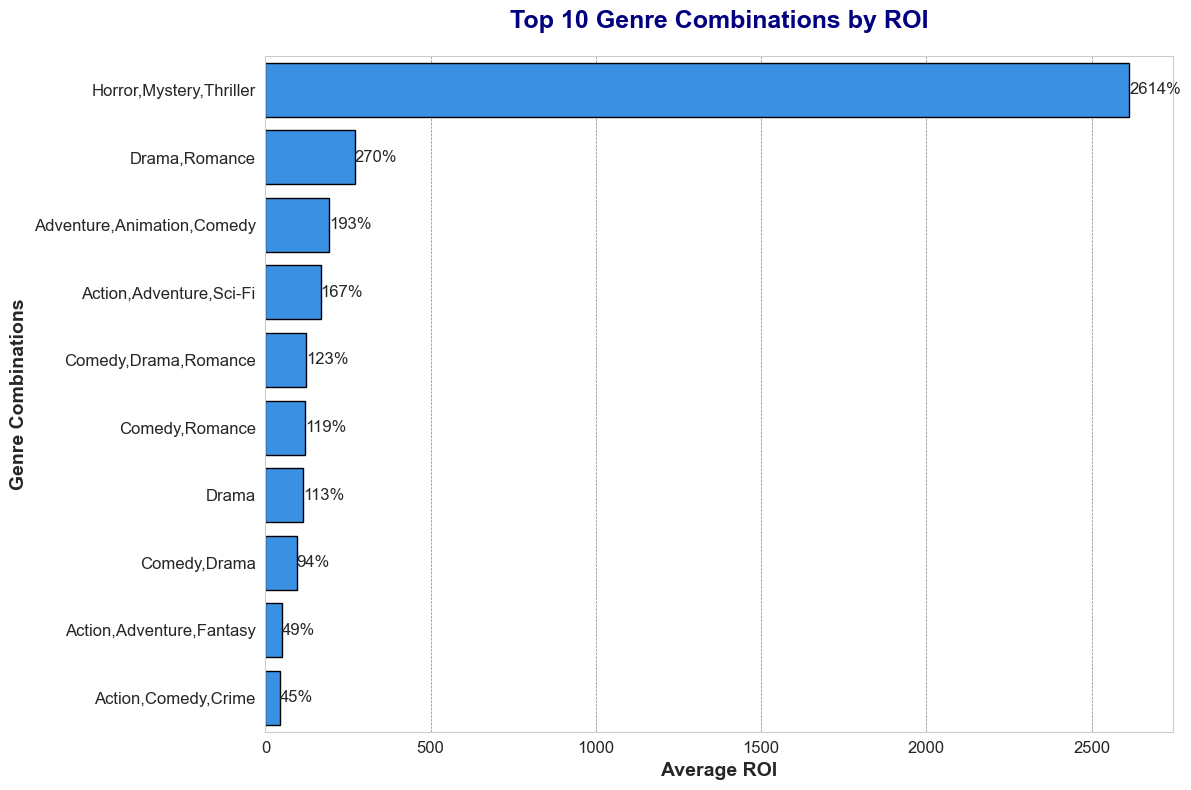

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set modern and professional style
sns.set_style("whitegrid")
plt.figure(figsize=(12, 8))

# Sort by 'avg_roi' to get the top 10 genre combinations
top_10_genres_by_roi = genre_combinations_analysis_filtered.nlargest(10, 'avg_roi')

# Create the bar plot with dodgerblue color
barplot = sns.barplot(x='avg_roi', y='genres', data=top_10_genres_by_roi, color='dodgerblue', edgecolor='black')

# Customize title and labels for a professional look
barplot.set_title('Top 10 Genre Combinations by ROI', fontsize=18, weight='bold', color='navy', pad=20)
barplot.set_xlabel('Average ROI', fontsize=14, weight='bold')
barplot.set_ylabel('Genre Combinations', fontsize=14, weight='bold')

# Add grid for better readability
barplot.xaxis.grid(True, color='gray', linestyle='--', linewidth=0.5)

# Customize ticks
barplot.tick_params(labelsize=12)

# Add value labels for each bar, rounded to integer
for i in barplot.containers:
    barplot.bar_label(i, fmt='%.0f%%', fontsize=12)  # Rounded to integer

# Show the plot
plt.tight_layout()
plt.show()

Now we can sort by average profit

In [49]:
# Sort by average profit to get the top profitable combinations
genre_combinations_analysis_filtered = genre_combinations_analysis_filtered.sort_values(by='avg_profit', ascending=False)

# Display the top 20 genre combinations based on average profit
genre_combinations_analysis_filtered.head(20)

,genres,count,avg_budget,avg_profit,avg_roi,avg_rating,total_votes
12,"Action,Adventure,Sci-Fi",55,169716363.64,467118871.35,166.97,6.73,22181507
63,"Adventure,Animation,Comedy",72,100090277.78,292000004.51,192.66,6.41,8178889
8,"Action,Adventure,Fantasy",33,149109090.91,247778337.39,48.95,6.12,7794508
225,"Horror,Mystery,Thriller",33,9721969.70,97892046.21,2614.19,5.53,2662668
6,"Action,Adventure,Drama",30,88153333.33,84898672.47,-17.70,5.96,3590583
21,"Action,Comedy,Crime",33,39930000.00,58148700.58,44.70,6.03,3794183
152,"Comedy,Romance",44,25565909.09,56749376.34,119.30,5.85,3215413
203,"Drama,Romance",35,22846857.14,54608913.46,270.25,6.82,3008082
117,Comedy,63,29061190.48,41244930.44,24.59,5.54,3906958
132,"Comedy,Drama,Romance",58,18023965.52,29467109.05,122.75,6.38,4758146


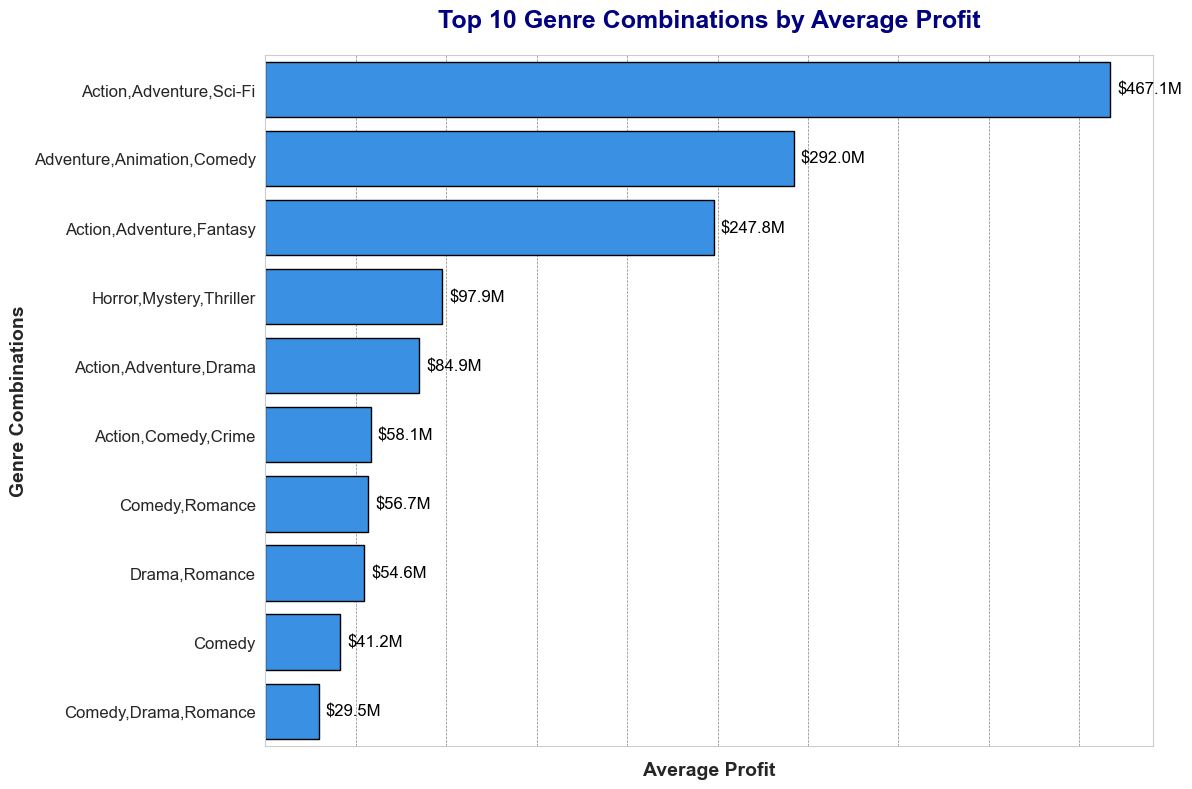

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

# Function to format numbers as currency with millions
def format_currency_millions(value):
    return f"${value / 1_000_000:.1f}M"  # Format as millions with one decimal place

# Set modern and professional style
sns.set_style("whitegrid")
plt.figure(figsize=(12, 8))

# Sort by 'avg_profit' to get the top 10 genre combinations
top_10_genres_by_profit = genre_combinations_analysis_filtered.nlargest(10, 'avg_profit')

# Create the bar plot with dodgerblue color
barplot = sns.barplot(x='avg_profit', y='genres', data=top_10_genres_by_profit, color='dodgerblue', edgecolor='black')

# Customize title and labels for a professional look
barplot.set_title('Top 10 Genre Combinations by Average Profit', fontsize=18, weight='bold', color='navy', pad=20)
barplot.set_xlabel('Average Profit', fontsize=14, weight='bold')  # Proper x-axis title
barplot.set_ylabel('Genre Combinations', fontsize=14, weight='bold')

# Add grid for better readability
barplot.xaxis.grid(True, color='gray', linestyle='--', linewidth=0.5)

# Remove x-axis tick values but keep the grid
barplot.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))  # Ensures grid lines are integer values
barplot.set_xticklabels([])  # Remove x-tick labels

# Customize tick parameters
barplot.tick_params(labelsize=12)

# Add value labels for each bar formatted as currency in millions, with adjusted positioning
for p in barplot.patches:
    barplot.annotate(format_currency_millions(p.get_x() + p.get_width()),  # Format the label
                     (p.get_x() + p.get_width(), p.get_y() + p.get_height() / 2),  # Position the label
                     ha='left', va='center', fontsize=12, color='black', 
                     xytext=(5, 0), textcoords='offset points')  # Offset from the bar

# Show the plot
plt.tight_layout()
plt.show()


## Horror, Mystery, Thriller 

### Find the most successful producers 

Find best producers for Horror, Mystery, or Thriller by the weighted score of (avg_roi * movie_count).
We can include all movies tagged as either Horror, Mystery, or Thriller:

In [51]:
# Create a mask for the specified genres
mask_genres_hmt = merged_df['genres'] == 'Horror,Mystery,Thriller'
mask_separate_genre_hmt = merged_df['genre1'].isin(['Horror', 'Mystery', 'Thriller']) | \
                 merged_df['genre2'].isin(['Horror', 'Mystery', 'Thriller']) | \
                 merged_df['genre3'].isin(['Horror', 'Mystery', 'Thriller'])

# Combine the masks
hmt_all_df = merged_df[mask_genres_hmt | mask_separate_genre_hmt]

If we want to include only specific genre category 'Horror,Mystery,Thriller'

In [52]:
# Filter the DataFrame for the specified genres
hmt_df = merged_df[merged_df['genres'] == 'Horror,Mystery,Thriller']

In [53]:
# Include separate genres
# Melt the producers into a single column
producers = pd.melt(hmt_all_df, id_vars=['profit', 'roi'], 
                    value_vars=['producer1', 'producer2'], 
                    var_name='producer_type', value_name='producer_name')

# Remove rows with NaN producers
producers = producers.dropna(subset=['producer_name'])

# Group by producer name and calculate average profit and movie count
producer_analysis = producers.groupby('producer_name').agg(
    avg_profit=('profit', 'mean'),
    avg_roi=('roi', 'mean'),
    movie_count=('roi', 'count')
).reset_index()

# Calculate a weighted score
producer_analysis['total_profit'] = producer_analysis['avg_profit'] * producer_analysis['movie_count']

# Sort by score to find the best producers
best_producers = producer_analysis.sort_values(by='total_profit', ascending=False)

# Display the top producers
best_producers.head(10)

,producer_name,avg_profit,avg_roi,movie_count,total_profit
368,Neal H. Moritz,862008239.75,372.68,4,3448032959.00
211,Jason Blum,85844562.28,2538.74,36,3090404242.00
340,Michael Fottrell,939577505.00,399.13,3,2818732515.00
125,David Heyman,709565120.50,499.49,2,1419130241.00
109,Dana Brunetti,255373029.25,457.40,4,1021492117.00
334,Michael Bay,112803038.22,1141.24,9,1015227344.00
338,Michael De Luca,202912027.20,344.20,5,1014560136.00
208,James Wan,190578607.60,2169.43,5,952893038.00
44,Barbara Broccoli,910526981.00,355.26,1,910526981.00
119,David Barron,453404490.00,293.65,2,906808980.00


In [54]:
# Include only specific genre category 'Horror,Mystery,Thriller'

# Melt the producers into a single column
producers = pd.melt(hmt_df, id_vars=['profit', 'roi'], 
                    value_vars=['producer1', 'producer2'], 
                    var_name='producer_type', value_name='producer_name')

# Remove rows with NaN producers
producers = producers.dropna(subset=['producer_name'])

# Group by producer name and calculate average profit and movie count
producer_analysis = producers.groupby('producer_name').agg(
    avg_profit=('profit', 'mean'),
    avg_roi=('roi', 'mean'),
    movie_count=('roi', 'count')
).reset_index()

# Calculate a weighted score
producer_analysis['total_profit'] = producer_analysis['avg_profit'] * producer_analysis['movie_count']

# Sort by score to find the best producers
best_producers = producer_analysis.sort_values(by='total_profit', ascending=False)

# Display the top producers
best_producers.head(10)

,producer_name,avg_profit,avg_roi,movie_count,total_profit
8,Jason Blum,129855601.64,5012.65,14,1817978423.00
7,James Wan,202271632.00,2017.76,4,809086528.00
19,Peter Safran,270373892.50,2793.82,2,540747785.00
26,Sean McKittrick,242289130.50,2989.21,2,484578261.00
30,Tony DeRosa-Grund,298000141.00,1390.00,1,298000141.00
20,Rob Cowan,298000141.00,1390.00,1,298000141.00
28,Steven Schneider,202039844.00,3940.80,1,202039844.00
18,Oren Peli,156921515.00,3038.43,1,156921515.00
16,Michael Bay,98300632.00,1866.01,1,98300632.00
14,Marc Bienstock,93677816.00,1773.56,1,93677816.00


### Find the most successful directors

Find best directors for Horror, Mystery, or Thriller by the weighted score of (avg_roi * movie_count). 

Include separate genres

In [55]:
# Melt the directors into a single column
directors = pd.melt(hmt_all_df, id_vars=['profit', 'roi'], 
                    value_vars=['director1', 'director2'], 
                    var_name='director_type', value_name='director_name')

# Remove rows with NaN producers
directors = directors.dropna(subset=['director_name'])

# Group by director name and calculate average roi and movie count
director_analysis = directors.groupby('director_name').agg(
    avg_profit=('profit', 'mean'),
    avg_roi=('roi', 'mean'),
    movie_count=('roi', 'count')
).reset_index()

# Calculate a weighted score
director_analysis['total_profit'] = director_analysis['avg_profit'] * director_analysis['movie_count']

# Sort by score to find the best director
best_directors = director_analysis.sort_values(by='total_profit', ascending=False)

# Display the top directors
best_directors.head(10)

,director_name,avg_profit,avg_roi,movie_count,total_profit
150,James Wan,594548150.00,1675.92,3,1783644450.00
310,Sam Mendes,745073952.00,224.24,2,1490147904.00
188,Justin Lin,567231949.00,298.72,2,1134463898.00
111,F. Gary Gray,984846267.00,293.94,1,984846267.00
87,David Yates,835431568.00,568.35,1,835431568.00
53,Christopher Nolan,809439099.00,194.34,1,809439099.00
18,Andy Muschietti,397776767.50,1290.02,2,795553535.00
52,Christopher McQuarrie,383413644.00,202.34,2,766827288.00
304,Ruben Fleischer,737628605.00,535.89,1,737628605.00
253,Neil Boultby,623008101.00,256.00,1,623008101.00


Include only specific genre category 'Horror,Mystery,Thriller'

In [56]:
# Melt the producers into a single column
directors = pd.melt(hmt_df, id_vars=['profit', 'roi'], 
                    value_vars=['director1', 'director2'], 
                    var_name='director_type', value_name='director_name')

# Remove rows with NaN producers
directors = directors.dropna(subset=['director_name'])

# Group by director name and calculate average roi and movie count
director_analysis = directors.groupby('director_name').agg(
    avg_profit=('profit', 'mean'),
    avg_roi=('roi', 'mean'),
    movie_count=('roi', 'count')
).reset_index()

# Calculate a weighted score
director_analysis['total_profit'] = director_analysis['avg_profit'] * director_analysis['movie_count']

# Sort by score to find the best director
best_directors = director_analysis.sort_values(by='total_profit', ascending=False)

# Display the top directors
best_directors.head(10)

,director_name,avg_profit,avg_roi,movie_count,total_profit
18,Jordan Peele,242289130.50,2989.21,2,484578261.00
14,James Wan,227460828.00,2214.22,2,454921656.00
2,Ariel Schulman,169928918.00,3298.58,2,339857836.00
13,Henry Joost,169928918.00,3298.58,2,339857836.00
9,David F. Sandberg,290384865.00,1835.90,1,290384865.00
17,John R. Leonetti,250362920.00,3751.74,1,250362920.00
6,Christopher Landon,102957557.00,1959.15,2,205915114.00
0,Adam Robitel,157885588.00,1478.86,1,157885588.00
25,Scott Derrickson,71342212.50,1408.72,2,142684425.00
20,Leigh Whannell,110453155.00,1004.53,1,110453155.00


### Find the most successful actresses

Find top 10 actresses based on score(total profit = avg_profit * movie_count).

Include separate genres

In [57]:
# Combine all actress columns into a single column for analysis
actresses_df = hmt_all_df.melt(id_vars=['profit', 'roi'], value_vars=['actress1', 'actress2', 'actress3'],
                                var_name='actress_rank', value_name='actress')

# Remove rows with missing actress values
actresses_df = actresses_df[actresses_df['actress'].notna()]

# Group by actress and calculate average profit, ROI, and total movies
best_actresses = actresses_df.groupby('actress').agg(
    avg_profit=('profit', 'mean'),
    avg_roi=('roi', 'mean'),
    movie_count=('actress', 'size')  # Count how many movies each actress appeared in
).reset_index()

# Calculate a weighted score
best_actresses['total_profit'] = best_actresses['avg_profit'] * best_actresses['movie_count']

# Sort by avg_profit to find the best actresses
best_actresses = best_actresses.sort_values(by='total_profit', ascending=False)

best_actresses.head(10)

,actress,avg_profit,avg_roi,movie_count,total_profit
341,Michelle Rodriguez,371506279.60,182.62,5,1857531398.00
239,Judi Dench,600724855.50,392.11,2,1201449711.00
363,Naomie Harris,910526981.00,355.26,1,910526981.00
161,Emma Watson,284635935.33,157.77,3,853907806.00
154,Eloise Mumford,423674360.00,851.34,2,847348720.00
124,Dakota Johnson,281517699.67,531.31,3,844553099.00
49,Anne Hathaway,397903064.00,19.90,2,795806128.00
344,Michelle Williams,737628605.00,535.89,1,737628605.00
453,Sophia Lillis,662457969.00,1792.74,1,662457969.00
364,Natalia Kaverznikova,623008101.00,256.00,1,623008101.00


In [58]:
# Find top 10 actresses based on score(total profit = avg_profit * movie_count)
# Don't Include separate genres

# Combine all actress columns into a single column for analysis
actresses_df = hmt_df.melt(id_vars=['profit', 'roi'], value_vars=['actress1', 'actress2', 'actress3'],
                                var_name='actress_rank', value_name='actress')

# Remove rows with missing actress values
actresses_df = actresses_df[actresses_df['actress'].notna()]

# Group by actress and calculate average profit, ROI, and total movies
best_actresses = actresses_df.groupby('actress').agg(
    avg_profit=('profit', 'mean'),
    avg_roi=('roi', 'mean'),
    movie_count=('actress', 'size')  # Count how many movies each actress appeared in
).reset_index()

# Calculate a weighted score
best_actresses['total_profit'] = best_actresses['avg_profit'] * best_actresses['movie_count']

# Sort by avg_profit to find the best actresses
best_actresses = best_actresses.sort_values(by='total_profit', ascending=False)

best_actresses.head(10)

,actress,avg_profit,avg_roi,movie_count,total_profit
35,Lin Shaye,157403551.50,2258.64,2,314807103.00
55,Vera Farmiga,298000141.00,1390.00,1,298000141.00
34,Lili Taylor,298000141.00,1390.00,1,298000141.00
50,Samara Lee,290384865.00,1835.90,1,290384865.00
38,Miranda Otto,290384865.00,1835.90,1,290384865.00
2,Allison Williams,250367951.00,4907.36,1,250367951.00
14,Catherine Keener,250367951.00,4907.36,1,250367951.00
0,Alfre Woodard,250362920.00,3751.74,1,250362920.00
5,Annabelle Wallis,250362920.00,3751.74,1,250362920.00
36,Lupita Nyong'o,234210310.00,1071.05,1,234210310.00


### Find the most successful actors

Find top 10 actors based on score(total profit = avg_profit * movie_count).

Include separate genres

In [59]:
# Combine all actor columns into a single column for analysis
actors_df = hmt_all_df.melt(id_vars=['profit', 'roi'], value_vars=['actor1', 'actor2', 'actor3', 'actor4'],
                                var_name='actor_rank', value_name='actor')

# Remove rows with missing actor values
actors_df = actors_df[actors_df['actor'].notna()]

# Group by actress and calculate average profit, ROI, and total movies
best_actors = actors_df.groupby('actor').agg(
    avg_profit=('profit', 'mean'),
    avg_roi=('roi', 'mean'),
    movie_count=('actor', 'size')  # Count how many movies each actor appeared in
).reset_index()

# Calculate a weighted score
best_actors['total_profit'] = best_actors['avg_profit'] * best_actors['movie_count']

# Sort by avg_profit to find the best actor
best_actors = best_actors.sort_values(by='total_profit', ascending=False)

best_actors.head(10)

,actor,avg_profit,avg_roi,movie_count,total_profit
774,Vin Diesel,741613263.60,339.33,5,3708066318.00
214,Dwayne Johnson,611676037.83,286.68,6,3670056227.00
336,Jason Statham,282868960.91,88.57,11,3111558570.00
592,Paul Walker,821062230.67,398.92,3,2463186692.00
156,Daniel Craig,407791010.00,99.43,4,1631164040.00
748,Tom Hardy,535840171.67,306.03,3,1607520515.00
256,Gary Oldman,207737957.20,123.45,5,1038689786.00
339,Javier Bardem,323022463.67,127.02,3,969067391.00
161,Daniel Radcliffe,313503944.33,368.62,3,940511833.00
745,Tom Cruise,288924592.33,157.08,3,866773777.00


In [60]:
# Find top 10 actors based on score(total profit = avg_profit * movie_count)
# Don't Include separate genres

# Combine all actor columns into a single column for analysis
actors_df = hmt_df.melt(id_vars=['profit', 'roi'], value_vars=['actor1', 'actor2', 'actor3', 'actor4'],
                                var_name='actor_rank', value_name='actor')

# Remove rows with missing actor values
actors_df = actors_df[actors_df['actor'].notna()]

# Group by actress and calculate average profit, ROI, and total movies
best_actors = actors_df.groupby('actor').agg(
    avg_profit=('profit', 'mean'),
    avg_roi=('roi', 'mean'),
    movie_count=('actor', 'size')  # Count how many movies each actor appeared in
).reset_index()

# Calculate a weighted score
best_actors['total_profit'] = best_actors['avg_profit'] * best_actors['movie_count']

# Sort by avg_profit to find the best actor
best_actors = best_actors.sort_values(by='total_profit', ascending=False)

best_actors.head(10)

,actor,avg_profit,avg_roi,movie_count,total_profit
50,Patrick Wilson,227460828.00,2214.22,2,454921656.00
55,Ron Livingston,298000141.00,1390.00,1,298000141.00
2,Anthony LaPaglia,290384865.00,1835.90,1,290384865.00
5,Brad Greenquist,290384865.00,1835.90,1,290384865.00
1,Angus Sampson,134169371.50,1241.69,2,268338743.00
43,Leigh Whannell,134169371.50,1241.69,2,268338743.00
15,Daniel Kaluuya,250367951.00,4907.36,1,250367951.00
6,Bradley Whitford,250367951.00,4907.36,1,250367951.00
65,Ward Horton,250362920.00,3751.74,1,250362920.00
63,Tony Amendola,250362920.00,3751.74,1,250362920.00


## Action, Adventure, Sci-Fi (maximize profit)

### Find the most successful producers

Find best producers for Action, Adventure, or Sci-Fi by the weighted score of (avg_profit * movie_count).

Include either genre

In [61]:
aasf_all_df = merged_df[
    (merged_df['genre1'].isin(['Action', 'Adventure', 'Sci-Fi'])) |
    (merged_df['genre2'].isin(['Action', 'Adventure', 'Sci-Fi'])) |
    (merged_df['genre3'].isin(['Action', 'Adventure', 'Sci-Fi']))
]

In [62]:
# To include only specific genre category 'Action,Adventure,Sci-Fi'
# Filter the DataFrame for the specified genres
aasf_df = merged_df[merged_df['genres'] == 'Action,Adventure,Sci-Fi']

In [63]:
# Include separate genres

# Melt the producers into a single column
producers = pd.melt(aasf_all_df, id_vars=['profit'], 
                    value_vars=['producer1', 'producer2'], 
                    var_name='producer_type', value_name='producer_name')

# Remove rows with NaN producers
producers = producers.dropna(subset=['producer_name'])

# Group by producer name and calculate average profit and movie count
producer_analysis = producers.groupby('producer_name').agg(
    avg_profit=('profit', 'mean'),
    movie_count=('profit', 'count')
).reset_index()

# Calculate a weighted score
producer_analysis['total_profit'] = producer_analysis['avg_profit'] * producer_analysis['movie_count']

# Sort by score to find the best producers
best_producers = producer_analysis.sort_values(by='total_profit', ascending=False)

# Display the top producers
best_producers.head(10)

,producer_name,avg_profit,movie_count,total_profit
317,Kevin Feige,867273996.00,6,5203643976.00
433,Neal H. Moritz,382036802.55,11,4202404828.00
248,Janet Healy,758076557.60,5,3790382788.00
137,David Heyman,742089267.40,5,3710446337.00
404,Michael Fottrell,746481830.00,4,2985927320.00
454,Patrick Crowley,569513682.40,5,2847568412.00
442,Nina Jacobson,615838336.00,4,2463353344.00
291,Jon Kilik,487318119.20,5,2436590596.00
598,Wyck Godfrey,471072595.20,5,2355362976.00
175,Emma Thomas,584045121.00,4,2336180484.00


In [64]:
# Include only specific genre category 'Action,Adventure,Sci-Fi'

# Melt the producers into a single column
producers = pd.melt(aasf_df, id_vars=['profit'], 
                    value_vars=['producer1', 'producer2'], 
                    var_name='producer_type', value_name='producer_name')

# Remove rows with NaN producers
producers = producers.dropna(subset=['producer_name'])

# Group by producer name and calculate average profit and movie count
producer_analysis = producers.groupby('producer_name').agg(
    avg_profit=('profit', 'mean'),
    movie_count=('profit', 'count')
).reset_index()

# Calculate a weighted score
producer_analysis['total_profit'] = producer_analysis['avg_profit'] * producer_analysis['movie_count']

# Sort by score to find the best producers
best_producers = producer_analysis.sort_values(by='total_profit', ascending=False)

# Display the top producers
best_producers.head(10)

,producer_name,avg_profit,movie_count,total_profit
23,Kevin Feige,938447882.00,5,4692239410.00
32,Patrick Crowley,1284813831.50,2,2569627663.00
21,Jon Kilik,615838336.00,4,2463353344.00
30,Nina Jacobson,615838336.00,4,2463353344.00
16,Ian Bryce,736240986.33,3,2208722959.00
7,Don Murphy,728675069.33,3,2186025208.00
1,Belén Atienza,1135772799.00,1,1135772799.00
13,Emma Thomas,675524642.00,1,675524642.00
8,Donald De Line,224412814.00,2,448825628.00
5,Charles Roven,442999518.00,1,442999518.00


### Find the most successful directors

In [65]:
# Find best directors for Action,Adventure,Sci-Fi by the weighted score of (avg_profit * movie_count)
# Include separate genres

# Melt the directors into a single column
directors = pd.melt(aasf_all_df, id_vars=['profit'], 
                    value_vars=['director1', 'director2'], 
                    var_name='director_type', value_name='director_name')

# Remove rows with NaN producers
directors = directors.dropna(subset=['director_name'])

# Group by director name and calculate average roi and movie count
director_analysis = directors.groupby('director_name').agg(
    avg_profit=('profit', 'mean'),
    movie_count=('profit', 'count')
).reset_index()

# Calculate a weighted score
director_analysis['total_profit'] = director_analysis['avg_profit'] * director_analysis['movie_count']

# Sort by score to find the best director
best_directors = director_analysis.sort_values(by='total_profit', ascending=False)

# Display the top directors
best_directors.head(10)

,director_name,avg_profit,movie_count,total_profit
139,David Yates,659129937.80,5,3295649689.00
246,Joe Russo,1060868500.67,3,3182605502.00
34,Anthony Russo,1060868500.67,3,3182605502.00
402,Pierre Coffin,981760252.67,3,2945280758.00
280,Joss Whedon,1182674930.00,2,2365349860.00
104,Christopher Nolan,584045121.00,4,2336180484.00
227,James Wan,1157808717.00,2,2315617434.00
340,Michael Bay,565999562.50,4,2263998250.00
392,Peter Jackson,724316014.67,3,2172948044.00
304,Kyle Balda,1023031961.50,2,2046063923.00


In [66]:
# Don't include separate genres

# Melt the directors into a single column
directors = pd.melt(aasf_df, id_vars=['profit'], 
                    value_vars=['director1', 'director2'], 
                    var_name='director_type', value_name='director_name')

# Remove rows with NaN producers
directors = directors.dropna(subset=['director_name'])

# Group by director name and calculate average roi and movie count
director_analysis = directors.groupby('director_name').agg(
    avg_profit=('profit', 'mean'),
    movie_count=('profit', 'count')
).reset_index()

# Calculate a weighted score
director_analysis['total_profit'] = director_analysis['avg_profit'] * director_analysis['movie_count']

# Sort by score to find the best director
best_directors = director_analysis.sort_values(by='total_profit', ascending=False)

# Display the top directors
best_directors.head(10)

,director_name,avg_profit,movie_count,total_profit
3,Anthony Russo,1060868500.67,3,3182605502.00
20,Joe Russo,1060868500.67,3,3182605502.00
25,Joss Whedon,1182674930.00,2,2365349860.00
33,Michael Bay,736240986.33,3,2208722959.00
11,Francis Lawrence,621809988.33,3,1865429965.00
7,Colin Trevorrow,1433854864.00,1,1433854864.00
12,Gareth Edwards,609089462.50,2,1218178925.00
38,Ryan Coogler,1148258224.00,1,1148258224.00
16,J.A. Bayona,1135772799.00,1,1135772799.00
40,Shane Black,543439917.50,2,1086879835.00


### Find the most successful actresses

In [67]:
# Find top 10 actresses based on score(total profit = avg_profit * movie_count)
# Include separate genres

# Combine all actress columns into a single column for analysis
actresses_df = aasf_all_df.melt(id_vars=['profit', 'roi'], value_vars=['actress1', 'actress2', 'actress3'],
                                var_name='actress_rank', value_name='actress')

# Remove rows with missing actress values
actresses_df = actresses_df[actresses_df['actress'].notna()]

# Group by actress and calculate average profit, ROI, and total movies
best_actresses = actresses_df.groupby('actress').agg(
    avg_profit=('profit', 'mean'),
    avg_roi=('roi', 'mean'),
    movie_count=('actress', 'size')  # Count how many movies each actress appeared in
).reset_index()

# Calculate a weighted score
best_actresses['total_profit'] = best_actresses['avg_profit'] * best_actresses['movie_count']

# Sort by avg_profit to find the best actresses
best_actresses = best_actresses.sort_values(by='total_profit', ascending=False)

best_actresses.head(10)

,actress,avg_profit,avg_roi,movie_count,total_profit
484,Scarlett Johansson,640565133.00,369.46,5,3202825665.00
230,Jennifer Lawrence,343583675.33,198.62,9,3092253078.00
47,Anne Hathaway,427138689.29,148.59,7,2989970825.00
299,Kristen Wiig,372930618.86,426.61,7,2610514332.00
76,Bryce Dallas Howard,1284813831.50,567.51,2,2569627663.00
88,Cate Blanchett,395034149.67,141.09,6,2370204898.00
155,Emma Watson,574401913.50,384.74,4,2297607654.00
298,Kristen Stewart,425372878.00,306.48,5,2126864390.00
377,Michelle Rodriguez,393425857.20,206.68,5,1967129286.00
391,Miranda Cosgrove,929472292.50,1131.41,2,1858944585.00


In [68]:
# Don't include separate genres

# Combine all actress columns into a single column for analysis
actresses_df = aasf_df.melt(id_vars=['profit', 'roi'], value_vars=['actress1', 'actress2', 'actress3'],
                                var_name='actress_rank', value_name='actress')

# Remove rows with missing actress values
actresses_df = actresses_df[actresses_df['actress'].notna()]

# Group by actress and calculate average profit, ROI, and total movies
best_actresses = actresses_df.groupby('actress').agg(
    avg_profit=('profit', 'mean'),
    avg_roi=('roi', 'mean'),
    movie_count=('actress', 'size')  # Count how many movies each actress appeared in
).reset_index()

# Calculate a weighted score
best_actresses['total_profit'] = best_actresses['avg_profit'] * best_actresses['movie_count']

# Sort by avg_profit to find the best actresses
best_actresses = best_actresses.sort_values(by='total_profit', ascending=False)

best_actresses.head(10)

,actress,avg_profit,avg_roi,movie_count,total_profit
24,Jennifer Lawrence,403294506.43,243.04,7,2823061545.00
47,Scarlett Johansson,909135733.00,316.97,3,2727407199.00
8,Bryce Dallas Howard,1284813831.50,567.51,2,2569627663.00
20,Gwyneth Paltrow,733274330.50,286.54,2,1466548661.00
25,Judy Greer,1433854864.00,566.91,1,1433854864.00
29,Lupita Nyong'o,1148258224.00,474.13,1,1148258224.00
11,Danai Gurira,1148258224.00,474.13,1,1148258224.00
18,Emma Stone,523443301.50,149.50,2,1046886603.00
6,Brie Larson,948061550.00,441.75,1,948061550.00
45,Rosie Huntington-Whiteley,928790543.00,376.30,1,928790543.00


### Find the most successful actor

In [69]:
# Find top 10 actors based on score(total profit = avg_profit * movie_count)
# Include separate genres

# Combine all actors columns into a single column for analysis
actors_df = aasf_all_df.melt(id_vars=['profit', 'roi'], value_vars=['actor1', 'actor2', 'actor3', 'actor4'],
                                var_name='actor_rank', value_name='actor')

# Remove rows with missing actress values
actors_df = actors_df[actors_df['actor'].notna()]

# Group by actor and calculate average profit, ROI, and total movies
best_actors = actors_df.groupby('actor').agg(
    avg_profit=('profit', 'mean'),
    avg_roi=('roi', 'mean'),
    movie_count=('actor', 'size')  # Count how many movies each actor appeared in
).reset_index()

# Calculate a weighted score
best_actors['total_profit'] = best_actors['avg_profit'] * best_actors['movie_count']

# Sort by avg_profit to find the best actresses
best_actors = best_actors.sort_values(by='total_profit', ascending=False)

best_actors.head(10)

,actor,avg_profit,avg_roi,movie_count,total_profit
784,Robert Downey Jr.,859185663.33,296.45,9,7732670970.00
251,Dwayne Johnson,391458053.47,228.94,17,6654786909.00
139,Chris Evans,826198425.43,234.59,7,5783388978.00
952,Vin Diesel,564314748.56,243.79,9,5078832737.00
145,Chris Pratt,573328915.75,278.76,8,4586631326.00
140,Chris Hemsworth,381791670.75,78.33,12,4581500049.00
593,Mark Ruffalo,931463298.50,285.61,4,3725853194.00
403,Jason Statham,236651371.69,49.82,13,3076467832.00
562,Liam Hemsworth,482417004.00,312.73,6,2894502024.00
467,Johnny Depp,237449033.75,4.75,12,2849388405.00


In [70]:
# Don't include separate genres

# Combine all actors columns into a single column for analysis
actors_df = aasf_df.melt(id_vars=['profit', 'roi'], value_vars=['actor1', 'actor2', 'actor3', 'actor4'],
                                var_name='actor_rank', value_name='actor')

# Remove rows with missing actress values
actors_df = actors_df[actors_df['actor'].notna()]

# Group by actor and calculate average profit, ROI, and total movies
best_actors = actors_df.groupby('actor').agg(
    avg_profit=('profit', 'mean'),
    avg_roi=('roi', 'mean'),
    movie_count=('actor', 'size')  # Count how many movies each actor appeared in
).reset_index()

# Calculate a weighted score
best_actors['total_profit'] = best_actors['avg_profit'] * best_actors['movie_count']

# Sort by avg_profit to find the best actresses
best_actors = best_actors.sort_values(by='total_profit', ascending=False)

best_actors.head(10)

,actor,avg_profit,avg_roi,movie_count,total_profit
86,Robert Downey Jr.,1025038354.86,330.54,7,7175268484.00
20,Chris Evans,963087523.00,287.12,6,5778525138.00
69,Mark Ruffalo,1410274081.50,353.55,2,2820548163.00
21,Chris Hemsworth,1410274081.50,353.55,2,2820548163.00
65,Liam Hemsworth,536504553.60,352.88,5,2682522768.00
23,Chris Pratt,1284813831.50,567.51,2,2569627663.00
55,Josh Hutcherson,615838336.00,432.89,4,2463353344.00
90,Samuel L. Jackson,574344405.00,242.23,3,1723033215.00
95,Stanley Tucci,745981227.50,486.57,2,1491962455.00
27,Don Cheadle,733274330.50,286.54,2,1466548661.00
